# White Blood cells object detection  retinanet
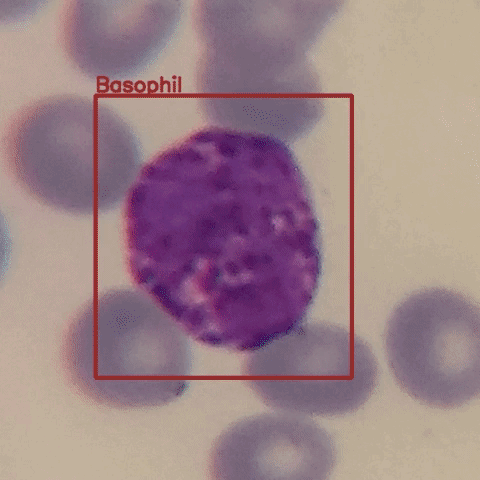

In [21]:
from config import (
    DEVICE, 
    NUM_CLASSES, 
    NUM_EPOCHS, 
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES, 
    NUM_WORKERS,
    RESIZE_TO,
    VALID_DIR,
    TRAIN_DIR
)

In [22]:
from model import create_model

In [23]:
from custom_utils import (
    Averager, 
    SaveBestModel, 
    save_model, 
    save_loss_plot,
    save_mAP
)

In [24]:
from datasets import (
    create_train_dataset, 
    create_valid_dataset, 
    create_train_loader, 
    create_valid_loader
)

In [25]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os

In [26]:
import tqdm

In [27]:
def train(train_data_loader, model):
    print('Training')
    model.train()
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value
# Function for running validation iterations.

In [28]:
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################
        

    metric.reset()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

In [29]:

os.makedirs('outputs', exist_ok=True)
train_dataset = create_train_dataset('data//train')
valid_dataset = create_valid_dataset('data//valid')
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# Initialize the model and move to the computation device.
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
scheduler = StepLR(
    optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
)

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
MODEL_NAME = 'model'

# Whether to show transformed images from data loader or not.
if VISUALIZE_TRANSFORMED_IMAGES:
    from custom_utils import show_tranformed_image
    show_tranformed_image(train_loader)

# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision()

Number of training samples: 5222
Number of validation samples: 2450

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, e


EPOCH 1 of 40
Training


Loss: 0.2448: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:19<00:00,  5.02it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:06<00:00,  9.26it/s]


Epoch #1 train loss: 0.404
Epoch #1 mAP: 0.6213173866271973
Took 5.493 minutes for epoch 0

BEST VALIDATION mAP: 0.6213173866271973

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 40
Training


Loss: 0.3967: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:17<00:00,  5.06it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.31it/s]


Epoch #2 train loss: 0.239
Epoch #2 mAP: 0.6812126636505127
Took 5.440 minutes for epoch 1

BEST VALIDATION mAP: 0.6812126636505127

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 40
Training


Loss: 0.1718: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:17<00:00,  5.06it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:04<00:00,  9.43it/s]


Epoch #3 train loss: 0.206
Epoch #3 mAP: 0.6872754096984863
Took 5.429 minutes for epoch 2

BEST VALIDATION mAP: 0.6872754096984863

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 40
Training


Loss: 0.1793: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:18<00:00,  5.04it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.41it/s]


Epoch #4 train loss: 0.187
Epoch #4 mAP: 0.7011764645576477
Took 5.439 minutes for epoch 3

BEST VALIDATION mAP: 0.7011764645576477

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 40
Training


Loss: 0.1584: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:18<00:00,  5.05it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.37it/s]


Epoch #5 train loss: 0.174
Epoch #5 mAP: 0.7127100229263306
Took 5.434 minutes for epoch 4

BEST VALIDATION mAP: 0.7127100229263306

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 40
Training


Loss: 0.2428: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:19<00:00,  5.02it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:06<00:00,  9.26it/s]


Epoch #6 train loss: 0.164
Epoch #6 mAP: 0.7009634971618652
Took 5.476 minutes for epoch 5
SAVING PLOTS COMPLETE...

EPOCH 7 of 40
Training


Loss: 0.1054: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:19<00:00,  5.04it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:06<00:00,  9.25it/s]


Epoch #7 train loss: 0.157
Epoch #7 mAP: 0.7171107530593872
Took 5.456 minutes for epoch 6

BEST VALIDATION mAP: 0.7171107530593872

SAVING BEST MODEL FOR EPOCH: 7

SAVING PLOTS COMPLETE...

EPOCH 8 of 40
Training


Loss: 0.1661: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:19<00:00,  5.03it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:06<00:00,  9.21it/s]


Epoch #8 train loss: 0.155
Epoch #8 mAP: 0.7161181569099426
Took 5.468 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 40
Training


Loss: 0.1243: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:18<00:00,  5.05it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.40it/s]


Epoch #9 train loss: 0.149
Epoch #9 mAP: 0.737044095993042
Took 5.430 minutes for epoch 8

BEST VALIDATION mAP: 0.737044095993042

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...

EPOCH 10 of 40
Training


Loss: 0.1516: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:17<00:00,  5.07it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.37it/s]


Epoch #10 train loss: 0.146
Epoch #10 mAP: 0.7014922499656677
Took 5.421 minutes for epoch 9
SAVING PLOTS COMPLETE...

EPOCH 11 of 40
Training


Loss: 0.1745: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:18<00:00,  5.05it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:04<00:00,  9.45it/s]


Epoch #11 train loss: 0.142
Epoch #11 mAP: 0.7042422294616699
Took 5.419 minutes for epoch 10
SAVING PLOTS COMPLETE...

EPOCH 12 of 40
Training


Loss: 0.1647: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:18<00:00,  5.05it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:05<00:00,  9.37it/s]


Epoch #12 train loss: 0.139
Epoch #12 mAP: 0.7255101203918457
Took 5.425 minutes for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 13 of 40
Training


Loss: 0.1379: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:17<00:00,  5.07it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:06<00:00,  9.23it/s]


Epoch #13 train loss: 0.140
Epoch #13 mAP: 0.713896632194519
Took 5.432 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 40
Training


Loss: 0.1608: 100%|████████████████████████████████████████████████████████████████| 1305/1305 [04:17<00:00,  5.06it/s]


Validating


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [01:04<00:00,  9.44it/s]


Epoch #14 train loss: 0.136
Epoch #14 mAP: 0.709306001663208
Took 5.414 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 40
Training


Loss: 0.1240:  61%|███████████████████████████████████████▍                         | 791/1305 [02:39<01:43,  4.96it/s]


KeyboardInterrupt: 

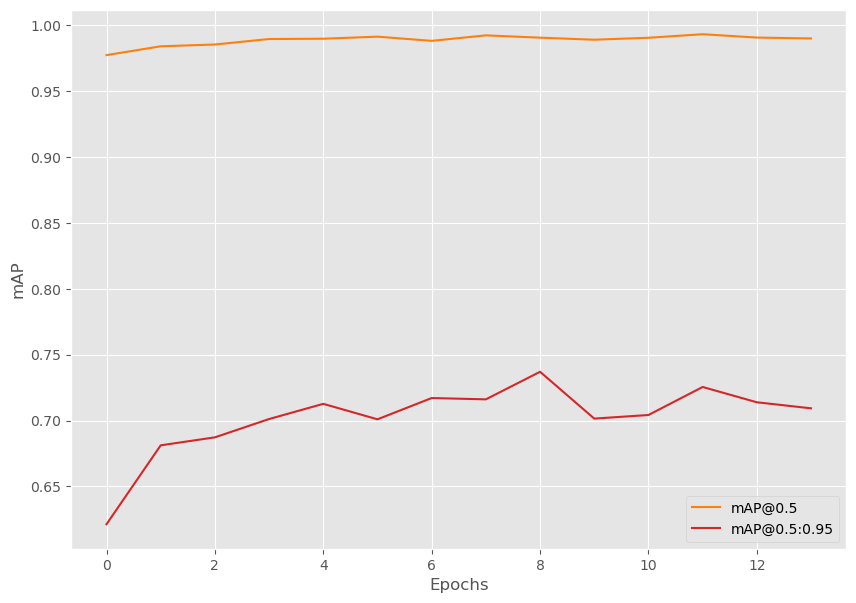

In [9]:
from tqdm import tqdm
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    # save the best model till now.
    save_best_model(
        model, float(metric_summary['map']), epoch, 'outputs'
    )
    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)
    #scheduler.step()

In [30]:
# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

test_dataset = create_valid_dataset(
    'data//test'
)
test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

metric_summary = validate(test_loader, model)
print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

Validating


TypeError: 'module' object is not callable

In [35]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time

from model import create_model

from config import (
    NUM_CLASSES, DEVICE, CLASSES
)

np.random.seed(42)

# Construct the argument parser.
i="data//test"

threshold=0.3


os.makedirs('inference_outputs/images', exist_ok=True)

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Directory where all the images are present.
DIR_TEST =i
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Total FPS till current frame.
    total_fps += fps
    frame_count += 1

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        print(scores)
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores == np.max(scores)].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            cv2.rectangle(orig_image,
                        (xmin, ymin),
                        (xmax, ymax),
                        color[::-1], 
                        3)
            cv2.putText(orig_image, 
                        class_name, 
                        (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, 
                        color[::-1], 
                        2, 
                        lineType=cv2.LINE_AA)

        cv2.imshow('Prediction', orig_image)
        cv2.waitKey(0)
        cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows() 
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Test instances: 5
(575, 575, 3)
[0.9804504  0.14328088 0.08191658 0.07001427 0.05802492 0.05010436]
Image 1 done...
--------------------------------------------------
(575, 575, 3)
[0.99374735 0.05780104]
Image 2 done...
--------------------------------------------------
(575, 575, 3)
[0.96154994 0.20780598 0.11988528 0.05526232]
Image 3 done...
--------------------------------------------------
(575, 575, 3)
[0.9869757  0.06395581 0.05293308]
Image 4 done...
--------------------------------------------------
(575, 575, 3)
[0.97055095 0.08397405 0.08181447 0.06110611]
Image 5 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE
Average FPS: 7.431
